## Content Moderation using Deep learning


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split, Subset


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, pad=0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=pad)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
        )
        self.pool_types = pool_types

    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                avg_pool = F.avg_pool2d(x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(avg_pool)
            elif pool_type == 'max':
                max_pool = F.max_pool2d(x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(max_pool)

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size - 1) // 2, relu=False)

    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out)  # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial = no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()

    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

class ContextBlock(nn.Module):
    def __init__(self, inplanes, ratio=1/16, pooling_type='att'):
        super(ContextBlock, self).__init__()
        assert pooling_type in ['avg', 'att']
        self.inplanes = inplanes
        self.ratio = ratio
        self.planes = int(inplanes * ratio)
        self.pooling_type = pooling_type

        if pooling_type == 'att':
            self.conv_mask = nn.Conv2d(inplanes, 1, kernel_size=1)
            self.softmax = nn.Softmax(dim=2)
        else:
            self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.channel_add_conv = nn.Sequential(
            nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
            nn.LayerNorm([self.planes, 1, 1]),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.planes, self.inplanes, kernel_size=1)
        )
        self.reset_parameters()

    def reset_parameters(self):
        if self.pooling_type == 'att':
            nn.init.kaiming_normal_(self.conv_mask.weight, mode='fan_in')
            self.conv_mask.inited = True

        nn.init.constant_(self.channel_add_conv[-1].weight, 0)
        nn.init.constant_(self.channel_add_conv[-1].bias, 0)

    def spatial_pool(self, x):
        batch, channel, height, width = x.size()
        if self.pooling_type == 'att':
            input_x = x.view(batch, channel, height * width)
            input_x = input_x.unsqueeze(1)
            context_mask = self.conv_mask(x).view(batch, 1, height * width)
            context_mask = self.softmax(context_mask).unsqueeze(-1)
            context = torch.matmul(input_x, context_mask).view(batch, channel, 1, 1)
        else:
            context = self.avg_pool(x)
        return context

    def forward(self, x):
        context = self.spatial_pool(x)
        channel_add_term = self.channel_add_conv(context)
        out = x + channel_add_term
        return out

class CustomModel(nn.Module):
    def __init__(self, in_channels=3, num_classes=5):
        super(CustomModel, self).__init__()
        self.conv1 = ConvBlock(in_channels, 8, 7, pad=3)
        self.conv2 = ConvBlock(8, 32, 7, pad=3)
        self.max_pool1 = nn.MaxPool2d(2)
        self.context1 = ContextBlock(32, ratio=1/8)
        
        self.conv3 = ConvBlock(32, 64, kernel_size=3, pad=1)
        self.context2 = ContextBlock(64, ratio=1/8)
        
        self.conv4 = ConvBlock(64, 512, kernel_size=3, pad=1)
        self.context3 = ContextBlock(512, ratio=1/8)
        
        self.conv5 = ConvBlock(128, 256, kernel_size=3, pad=1)
        self.context4 = ContextBlock(256, ratio=1/8)
        
        self.conv6 = ConvBlock(256, 512, kernel_size=3, pad=1)
        self.context5 = ContextBlock(512, ratio=1/8)
        
        self.conv7 = ConvBlock(512, 1024, kernel_size=3, pad=1)
        self.context6 = ContextBlock(1024, ratio=1/8)
        
        self.conv8 = ConvBlock(1024, 1024, kernel_size=3, pad=1)
        self.context7 = ContextBlock(1024, ratio=1/8)
        
        self.max_pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.bn2d = nn.BatchNorm2d(1024)
        self.cbam_block1 = CBAM(1024)  # Moved CBAM here
        self.fc1 = nn.Linear(1024 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.context1(x)
        x = self.max_pool1(x)

        x = self.conv3(x)
        x = self.context2(x)
        # x = self.max_pool2(x)

        x = self.conv4(x)
        x = self.context3(x)
        x = self.max_pool2(x)

        # x = self.conv5(x)
        # x = self.context4(x)
        x = self.max_pool2(x)

        # x = self.conv6(x)
        # x = self.context5(x)
        x = self.max_pool2(x)
        
        x = self.conv7(x)
        x = self.context6(x)
        # x = self.max_pool2(x)
        
        x = self.conv8(x)
        x = self.context7(x)
        x = self.max_pool2(x)
        x = self.cbam_block1(x)
        # print(x.shape)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# model = CustomModel()
# random_image = torch.randn(1, 3, 224, 224)
# # print(model)
# output = model(random_image)
# print(output.shape)


In [3]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3, pad=0):
#         super(ConvBlock, self).__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=pad)
#         self.bn = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.bn(x)
#         x = self.relu(x)
#         return x

# class BasicConv(nn.Module):
#     def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
#         super(BasicConv, self).__init__()
#         self.out_channels = out_planes
#         self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
#         self.bn = nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
#         self.relu = nn.ReLU() if relu else None

#     def forward(self, x):
#         x = self.conv(x)
#         if self.bn is not None:
#             x = self.bn(x)
#         if self.relu is not None:
#             x = self.relu(x)
#         return x

# class Flatten(nn.Module):
#     def forward(self, x):
#         return x.view(x.size(0), -1)

# class ChannelGate(nn.Module):
#     def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
#         super(ChannelGate, self).__init__()
#         self.gate_channels = gate_channels
#         self.mlp = nn.Sequential(
#             Flatten(),
#             nn.Linear(gate_channels, gate_channels // reduction_ratio),
#             nn.ReLU(),
#             nn.Linear(gate_channels // reduction_ratio, gate_channels)
#         )
#         self.pool_types = pool_types

#     def forward(self, x):
#         channel_att_sum = None
#         for pool_type in self.pool_types:
#             if pool_type == 'avg':
#                 avg_pool = F.avg_pool2d(x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
#                 channel_att_raw = self.mlp(avg_pool)
#             elif pool_type == 'max':
#                 max_pool = F.max_pool2d(x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
#                 channel_att_raw = self.mlp(max_pool)

#             if channel_att_sum is None:
#                 channel_att_sum = channel_att_raw
#             else:
#                 channel_att_sum = channel_att_sum + channel_att_raw

#         scale = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)
#         return x * scale

# class ChannelPool(nn.Module):
#     def forward(self, x):
#         return torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)

# class SpatialGate(nn.Module):
#     def __init__(self):
#         super(SpatialGate, self).__init__()
#         kernel_size = 7
#         self.compress = ChannelPool()
#         self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size - 1) // 2, relu=False)

#     def forward(self, x):
#         x_compress = self.compress(x)
#         x_out = self.spatial(x_compress)
#         scale = torch.sigmoid(x_out)  # broadcasting
#         return x * scale

# class CBAM(nn.Module):
#     def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
#         super(CBAM, self).__init__()
#         self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
#         self.no_spatial = no_spatial
#         if not no_spatial:
#             self.SpatialGate = SpatialGate()

#     def forward(self, x):
#         x_out = self.ChannelGate(x)
#         if not self.no_spatial:
#             x_out = self.SpatialGate(x_out)
#         return x_out

# class ContextBlock(nn.Module):
#     def __init__(self, inplanes, ratio=1/16, pooling_type='att'):
#         super(ContextBlock, self).__init__()
#         assert pooling_type in ['avg', 'att']
#         self.inplanes = inplanes
#         self.ratio = ratio
#         self.planes = int(inplanes * ratio)
#         self.pooling_type = pooling_type

#         if pooling_type == 'att':
#             self.conv_mask = nn.Conv2d(inplanes, 1, kernel_size=1)
#             self.softmax = nn.Softmax(dim=2)
#         else:
#             self.avg_pool = nn.AdaptiveAvgPool2d(1)

#         self.channel_add_conv = nn.Sequential(
#             nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
#             nn.LayerNorm([self.planes, 1, 1]),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(self.planes, self.inplanes, kernel_size=1)
#         )
#         self.reset_parameters()

#     def reset_parameters(self):
#         if self.pooling_type == 'att':
#             nn.init.kaiming_normal_(self.conv_mask.weight, mode='fan_in')
#             self.conv_mask.inited = True

#         nn.init.constant_(self.channel_add_conv[-1].weight, 0)
#         nn.init.constant_(self.channel_add_conv[-1].bias, 0)

#     def spatial_pool(self, x):
#         batch, channel, height, width = x.size()
#         if self.pooling_type == 'att':
#             input_x = x.view(batch, channel, height * width)
#             input_x = input_x.unsqueeze(1)
#             context_mask = self.conv_mask(x).view(batch, 1, height * width)
#             context_mask = self.softmax(context_mask).unsqueeze(-1)
#             context = torch.matmul(input_x, context_mask).view(batch, channel, 1, 1)
#         else:
#             context = self.avg_pool(x)
#         return context

#     def forward(self, x):
#         context = self.spatial_pool(x)
#         channel_add_term = self.channel_add_conv(context)
#         out = x + channel_add_term
#         return out

# class CustomModel(nn.Module):
#     def __init__(self, in_channels=3, num_classes=5):
#         super(CustomModel, self).__init__()
#         self.conv1 = ConvBlock(in_channels, 8, 7, pad=3)
#         self.conv2 = ConvBlock(8, 32, 7, pad=3)
#         self.max_pool1 = nn.MaxPool2d(2)
#         self.context1 = ContextBlock(32, ratio=1/8)
        
#         self.conv3 = ConvBlock(32, 64, kernel_size=3, pad=1)
#         self.context2 = ContextBlock(64, ratio=1/8)
        
#         self.conv4 = ConvBlock(64, 512, kernel_size=3, pad=1)
#         self.context3 = ContextBlock(512, ratio=1/8)
        
#         self.conv5 = ConvBlock(128, 256, kernel_size=3, pad=1)
#         self.context4 = ContextBlock(256, ratio=1/8)
        
#         self.conv6 = ConvBlock(256, 512, kernel_size=3, pad=1)
#         self.context5 = ContextBlock(512, ratio=1/8)
        
#         self.conv7 = ConvBlock(512, 1024, kernel_size=3, pad=1)
#         self.context6 = ContextBlock(1024, ratio=1/8)
        
#         self.conv8 = ConvBlock(512, 1024, kernel_size=3, pad=1)
#         self.context7 = ContextBlock(1024, ratio=1/8)
        
#         self.max_pool2 = nn.MaxPool2d(2)
#         self.flatten = nn.Flatten()
#         self.dropout = nn.Dropout(0.5)
#         self.bn2d = nn.BatchNorm2d(1024)
#         self.cbam_block1 = CBAM(1024)  # Moved CBAM here
#         self.fc1 = nn.Linear(1024 * 7 * 7, 512)
#         self.fc2 = nn.Linear(512, num_classes)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.context1(x)
#         x = self.max_pool1(x)

#         x = self.conv3(x)
#         x = self.context2(x)
#         # x = self.max_pool2(x)

#         x = self.conv4(x)
#         x = self.context3(x)
#         x = self.max_pool2(x)

#         # x = self.conv5(x)
#         # x = self.context4(x)
#         x = self.max_pool2(x)

#         # x = self.conv6(x)
#         # x = self.context5(x)
#         x = self.max_pool2(x)
        
#         # x = self.conv7(x)
#         # x = self.context6(x)
#         # x = self.max_pool2(x)
        
#         x = self.conv8(x)
#         x = self.context7(x)
#         x = self.max_pool2(x)
#         x = self.cbam_block1(x)
#         # print(x.shape)
#         x = self.flatten(x)
#         x = self.dropout(x)
#         x = self.fc1(x)
#         x = self.fc2(x)
#         return x

# # model = CustomModel()
# # random_image = torch.randn(1, 3, 224, 224)
# # # print(model)
# # output = model(random_image)
# # print(output.shape)


In [4]:
# import os
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader, random_split
# from sklearn.metrics import accuracy_score

# # Define paths
# data_dir = 'Dataset\Train'
# batch_size = 32

# # Define the image transformations
# transform = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Load the full dataset
# full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# # Define the split ratios
# train_ratio = 0.7
# val_ratio = 0.15
# test_ratio = 0.15

# # Calculate the lengths of each subset
# train_len = int(len(full_dataset) * train_ratio)
# val_len = int(len(full_dataset) * val_ratio)
# test_len = len(full_dataset) - train_len - val_len

# # Split the dataset
# gen=torch.Generator().manual_seed(4)
# train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_len, val_len, test_len],generator=gen)

# # Create DataLoaders for each subset
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Define the model, loss function, and optimizer
# model = CustomModel(in_channels=3, num_classes=5)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Add a learning rate scheduler
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# # Training function
# def train(model, train_loader, criterion, optimizer, device):
#     model.train()
#     running_loss = 0.0
#     all_preds = []
#     all_labels = []

#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * inputs.size(0)
#         _, preds = torch.max(outputs, 1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

#     epoch_loss = running_loss / len(train_loader.dataset)
#     epoch_acc = accuracy_score(all_labels, all_preds)
#     return epoch_loss, epoch_acc

# # Evaluation function
# def evaluate(model, val_loader, criterion, device):
#     model.eval()
#     running_loss = 0.0
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs, labels = inputs.to(device), labels.to(device)

#             outputs = model(inputs)
#             loss = criterion(outputs, labels)

#             running_loss += loss.item() * inputs.size(0)
#             _, preds = torch.max(outputs, 1)
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     epoch_loss = running_loss / len(val_loader.dataset)
#     epoch_acc = accuracy_score(all_labels, all_preds)
#     return epoch_loss, epoch_acc




In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score

# Define paths
data_dir = 'Dataset\Train'
batch_size = 32

# Define the image transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the full dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Use only 20% of the dataset
subset_ratio = 0.5
subset_len = int(len(full_dataset) * subset_ratio)
gen = torch.Generator().manual_seed(4)
subset_dataset, _ = random_split(full_dataset, [subset_len, len(full_dataset) - subset_len], generator=gen)

# Define the split ratios for the 20% subset
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the lengths of each subset
train_len = int(len(subset_dataset) * train_ratio)
val_len = int(len(subset_dataset) * val_ratio)
test_len = len(subset_dataset) - train_len - val_len

# Split the 20% subset into train, validation, and test datasets
train_dataset, val_dataset, test_dataset = random_split(subset_dataset, [train_len, val_len, test_len], generator=gen)

# Create DataLoaders for each subset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the model, loss function, and optimizer
model = CustomModel(in_channels=3, num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Add a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc


<>:10: SyntaxWarning: invalid escape sequence '\T'
<>:10: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Jeevan Prakash\AppData\Local\Temp\ipykernel_13460\3368368483.py:10: SyntaxWarning: invalid escape sequence '\T'
  data_dir = 'Dataset\Train'
e:\Python\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f'Using {device}')
num_epochs = 25

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Step the scheduler
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Evaluate on the test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'custom_modelbest1.pth')

# Save the metrics to a text file
with open('training_metricsbest1.txt', 'w') as f:
    f.write("Epoch\tTrain Loss\tTrain Acc\tVal Loss\tVal Acc\n")
    for epoch in range(num_epochs):
        f.write(f"{epoch+1}\t{train_losses[epoch]:.4f}\t{train_accuracies[epoch]:.4f}\t{val_losses[epoch]:.4f}\t{val_accuracies[epoch]:.4f}\n")
    f.write(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}\n")

Using cuda
Epoch 1/25
Train Loss: 1.8017, Train Acc: 0.4251
Val Loss: 1.2622, Val Acc: 0.4921
Epoch 2/25
Train Loss: 1.1382, Train Acc: 0.5496
Val Loss: 1.1069, Val Acc: 0.5570
Epoch 3/25
Train Loss: 0.9896, Train Acc: 0.6258
Val Loss: 1.0668, Val Acc: 0.5974
Epoch 4/25
Train Loss: 0.9167, Train Acc: 0.6544
Val Loss: 0.8283, Val Acc: 0.6936
Epoch 5/25
Train Loss: 0.8577, Train Acc: 0.6770
Val Loss: 0.8047, Val Acc: 0.7037
Epoch 6/25
Train Loss: 0.8020, Train Acc: 0.7065
Val Loss: 0.7834, Val Acc: 0.7128
Epoch 7/25
Train Loss: 0.7749, Train Acc: 0.7120
Val Loss: 0.8083, Val Acc: 0.7090
Epoch 8/25
Train Loss: 0.7310, Train Acc: 0.7371
Val Loss: 0.6772, Val Acc: 0.7480
Epoch 9/25
Train Loss: 0.7007, Train Acc: 0.7388
Val Loss: 0.7212, Val Acc: 0.7431
Epoch 10/25
Train Loss: 0.6725, Train Acc: 0.7569
Val Loss: 0.6845, Val Acc: 0.7672
Epoch 11/25
Train Loss: 0.6512, Train Acc: 0.7631
Val Loss: 0.7775, Val Acc: 0.7234


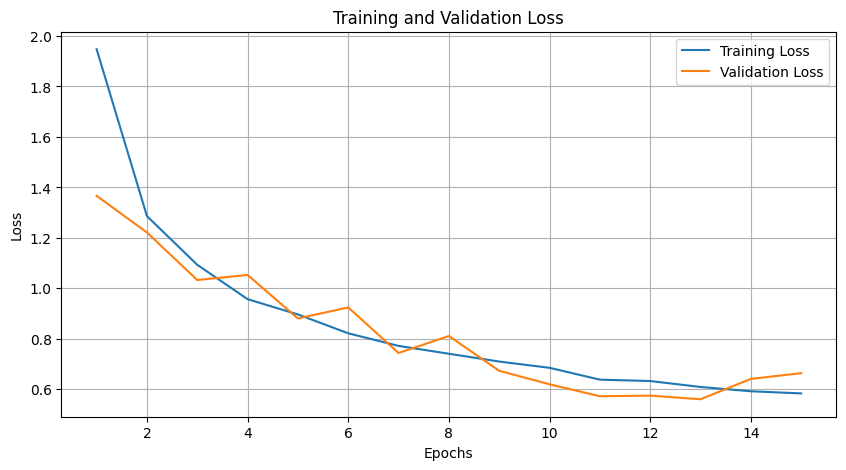

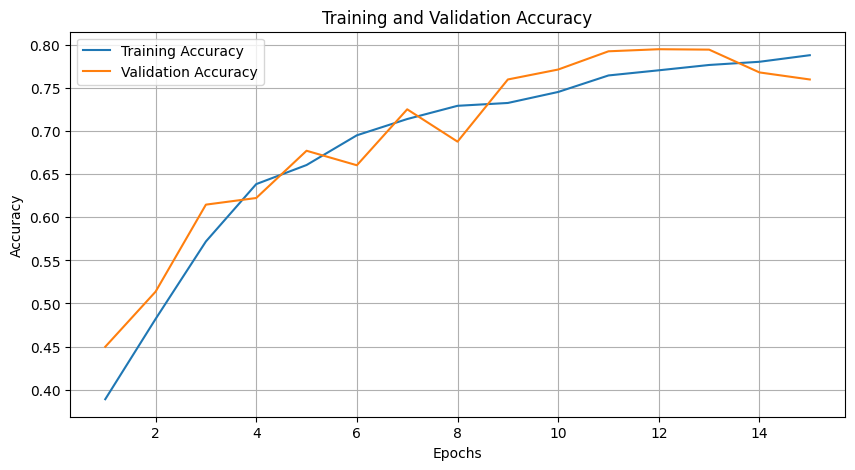

In [7]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
# plt.savefig('loss_plot.png')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
# plt.savefig('accuracy_plot.png')
plt.show()


In [8]:
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the saved model
model = CustomModel(in_channels=3, num_classes=5)
model.load_state_dict(torch.load('custom_modelbest3.pth'))
model = model.to(device)
model.eval()

# Function to calculate class-wise accuracy
def calculate_classwise_accuracy(model, test_loader, device, num_classes=5):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)

    for i in range(len(all_labels)):
        label = all_labels[i]
        pred = all_preds[i]
        if label == pred:
            class_correct[label] += 1
        class_total[label] += 1

    classwise_accuracy = class_correct / class_total
    return classwise_accuracy

# Calculate class-wise accuracy
classwise_accuracy = calculate_classwise_accuracy(model, test_loader, device)

# Print class-wise accuracy
for i in range(len(classwise_accuracy)):
    print(f"Class {i} Accuracy: {classwise_accuracy[i] * 100:.2f}%")

# Calculate overall accuracy
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

overall_accuracy = correct / total * 100
print(f'Overall Accuracy: {overall_accuracy:.2f}%')


C:\Users\Jeevan Prakash\AppData\Local\Temp\ipykernel_32592\1458323399.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('custom_modelbest3

Class 0 Accuracy: 80.75%
Class 1 Accuracy: 78.92%
Class 2 Accuracy: 94.93%
Class 3 Accuracy: 66.78%
Class 4 Accuracy: 63.77%
Overall Accuracy: 77.65%
